In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    'Steps': [3021, 5035, 7049, 9063, 11077, 13091, 15105, 17119],
    'Training Loss': [0.0908, 0.0644, 0.0598, 0.0457, 0.0442, 0.0432, 0.0313, 0.0303],
    'Validation Avg Loss': [3.584, 2.600, 2.658, 2.961, 3.458, 2.754, 2.619, 2.984],
    'Recall': [0.2346, 0.2298, 0.2451, 0.2259, 0.2519, 0.2403, 0.2490, 0.2346]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot 1: Training Loss and Recall
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the training loss on the primary y-axis
sns.lineplot(data=df, x='Steps', y='Training Loss', marker='o', label='Training Loss', ax=ax1)

# Set up the secondary axis for Recall
ax2 = ax1.twinx()
sns.lineplot(data=df, x='Steps', y='Recall', marker='s', label='Recall', ax=ax2, color='green')

# Set labels and title
ax1.set_xlabel('Steps')
ax1.set_ylabel('Training Loss')
ax2.set_ylabel('Recall')
ax1.set_title('Training Loss vs Recall')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Customize the secondary y-axis for Recall
ax2.set_ylim(0, 1)

# Customizing the plot
sns.despine(ax=ax1, right=False)  # Keep the right spine for the secondary axis
ax1.grid(False)  # Disable the grid

# Display the plot
plt.show()

In [1]:
# Plot 2: Validation Loss and Recall
fig, ax3 = plt.subplots(figsize=(10, 6))

# Plot the validation average loss on the primary y-axis
sns.lineplot(data=df, x='Steps', y='Validation Avg Loss', marker='x', label='Validation Avg Loss', ax=ax3)

# Set up the secondary axis for Recall
ax4 = ax3.twinx()
sns.lineplot(data=df, x='Steps', y='Recall', marker='s', label='Recall', ax=ax4, color='green')

# Set labels and title
ax3.set_xlabel('Steps')
ax3.set_ylabel('Validation Loss')
ax4.set_ylabel('Recall')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# Customize the secondary y-axis for Recall
ax4.set_ylim(0.1, 0.4)

# Customizing the plot
sns.despine(ax=ax3, right=False)  # Keep the right spine for the secondary axis
ax3.grid(False)  # Disable the grid

# Display the plot
plt.show()


NameError: name 'plt' is not defined

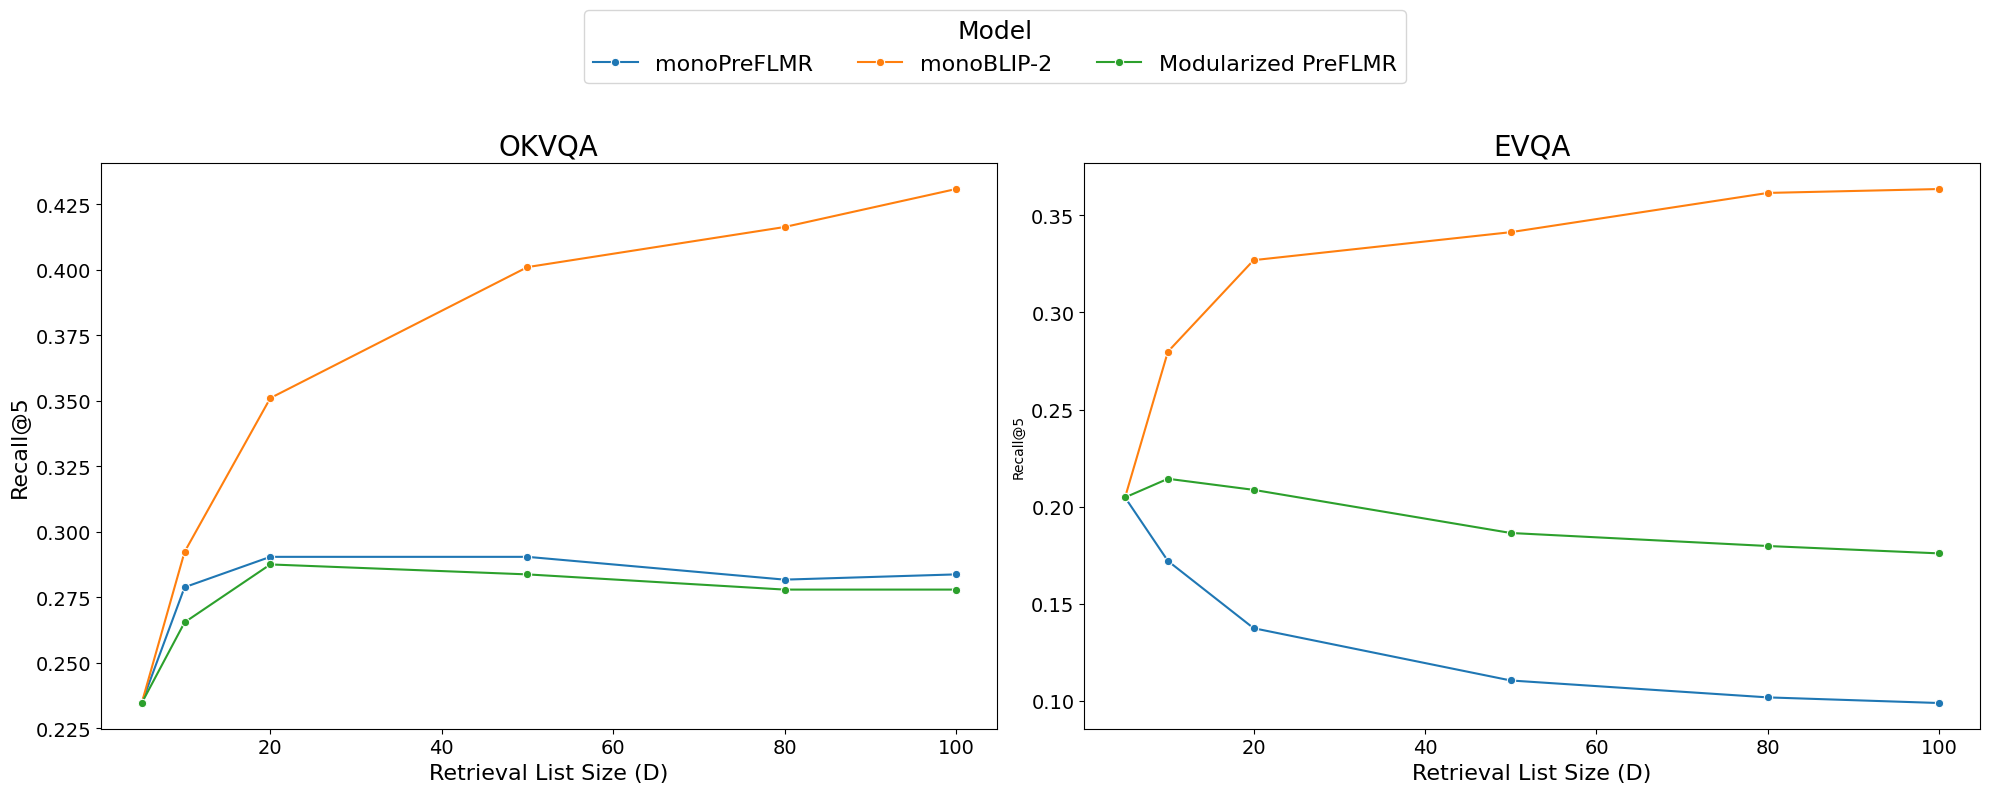

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation
data_okvqa = {
    'D': [5, 10, 20, 50, 80, 100],
    'monoPreFLMR': [0.2346, 0.2788, 0.2904, 0.2904, 0.2817, 0.2837],
    'monoBLIP-2': [0.2346, 0.2923, 0.3510, 0.4010, 0.4163, 0.4308],
    'Modularized PreFLMR': [0.2346, 0.2654, 0.2875, 0.2837, 0.2779, 0.2779]
}

data_evqa = {
    'D': [5, 10, 20, 50, 80, 100],
    'monoPreFLMR': [0.2048, 0.1721, 0.1375, 0.1106, 0.1019, 0.0990],
    'monoBLIP-2': [0.2048, 0.2798, 0.3269, 0.3413, 0.3615, 0.3635],
    'Modularized PreFLMR': [0.2048, 0.2144, 0.2087, 0.1865, 0.1798, 0.1760]
}

# Convert to DataFrame
df_okvqa = pd.DataFrame(data_okvqa)
df_evqa = pd.DataFrame(data_evqa)

# Melt the data for seaborn
df_okvqa_melt = df_okvqa.melt('D', var_name='Model', value_name='Recall@5')
df_evqa_melt = df_evqa.melt('D', var_name='Model', value_name='Recall@5')

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plot for OKVQA
sns.lineplot(ax=axes[0], data=df_okvqa_melt, x='D', y='Recall@5', hue='Model', marker='o')
axes[0].set_title('OKVQA', fontsize=20)
axes[0].set_xlabel('Retrieval List Size (D)', fontsize=16)
axes[0].set_ylabel('Recall@5', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend_.remove()  # Remove the individual legend
axes[0].grid(False)

# Plot for EVQA
sns.lineplot(ax=axes[1], data=df_evqa_melt, x='D', y='Recall@5', hue='Model', marker='o')
axes[1].set_title('EVQA', fontsize=20)
axes[1].set_xlabel('Retrieval List Size (D)', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend_.remove()  # Remove the individual legend
axes[1].grid(False)

# Add a single legend for both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, title='Model', fontsize=16, title_fontsize=18)

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()


/var/folders/31/6jrg6lvn55d02mn4dpsw9ry00000gn/T/ipykernel_38075/687966482.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


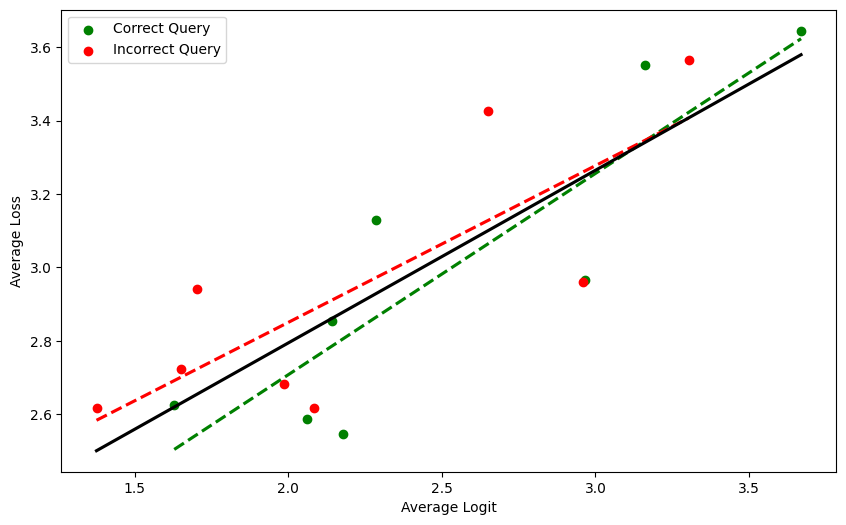

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
data = {
    'Step': [3021, 5035, 7049, 9063, 11077, 13091, 15105, 17119],
    'Training Loss': [0.0908, 0.0644, 0.0598, 0.0457, 0.0442, 0.0432, 0.0313, 0.0303],
    'Correct Avg Loss': [3.645, 2.545, 2.588, 2.966, 3.552, 2.853, 2.626, 3.130],
    'Correct Avg Logit': [3.669, 2.178, 2.062, 2.966, 3.160, 2.143, 1.629, 2.286],
    'Incorrect Loss': [3.566, 2.617, 2.681, 2.960, 3.427, 2.724, 2.617, 2.940],
    'Incorrect Avg Logit': [3.303, 2.083, 1.986, 2.960, 2.651, 1.651, 1.376, 1.703],
    'Validation Avg Loss': [3.584, 2.600, 2.658, 2.961, 3.458, 2.754, 2.619, 2.984],
    'Recall': [0.2346, 0.2298, 0.2451, 0.2259, 0.2519, 0.2403, 0.2490, 0.2346]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(10, 6))

# Scatter plot for correct documents
plt.scatter(df['Correct Avg Logit'], df['Correct Avg Loss'], color='green', label='Correct Query')

# Scatter plot for incorrect documents
plt.scatter(df['Incorrect Avg Logit'], df['Incorrect Loss'], color='red', label='Incorrect Query')


# Regression plot for correct documents
sns.regplot(x=df['Correct Avg Logit'], y=df['Correct Avg Loss'], scatter=False, color='green', line_kws={'linestyle': '--'}, ci = None)

# Regression plot for incorrect documents
sns.regplot(x=df['Incorrect Avg Logit'], y=df['Incorrect Loss'], scatter=False, color='red', line_kws={'linestyle': '--'}, ci = None)

# Overall regression plot
overall_avg_logit = df['Correct Avg Logit'].tolist() + df['Incorrect Avg Logit'].tolist()
overall_avg_loss = df['Correct Avg Loss'].tolist() + df['Incorrect Loss'].tolist()
sns.regplot(x=overall_avg_logit, y=overall_avg_loss, scatter=False, color='black', ci = None)

# Adding labels and title
plt.xlabel('Average Logit')
plt.ylabel('Average Loss')
# plt.title('Avg Loss vs Avg Logit')
plt.legend()


# Display the plot
plt.show()


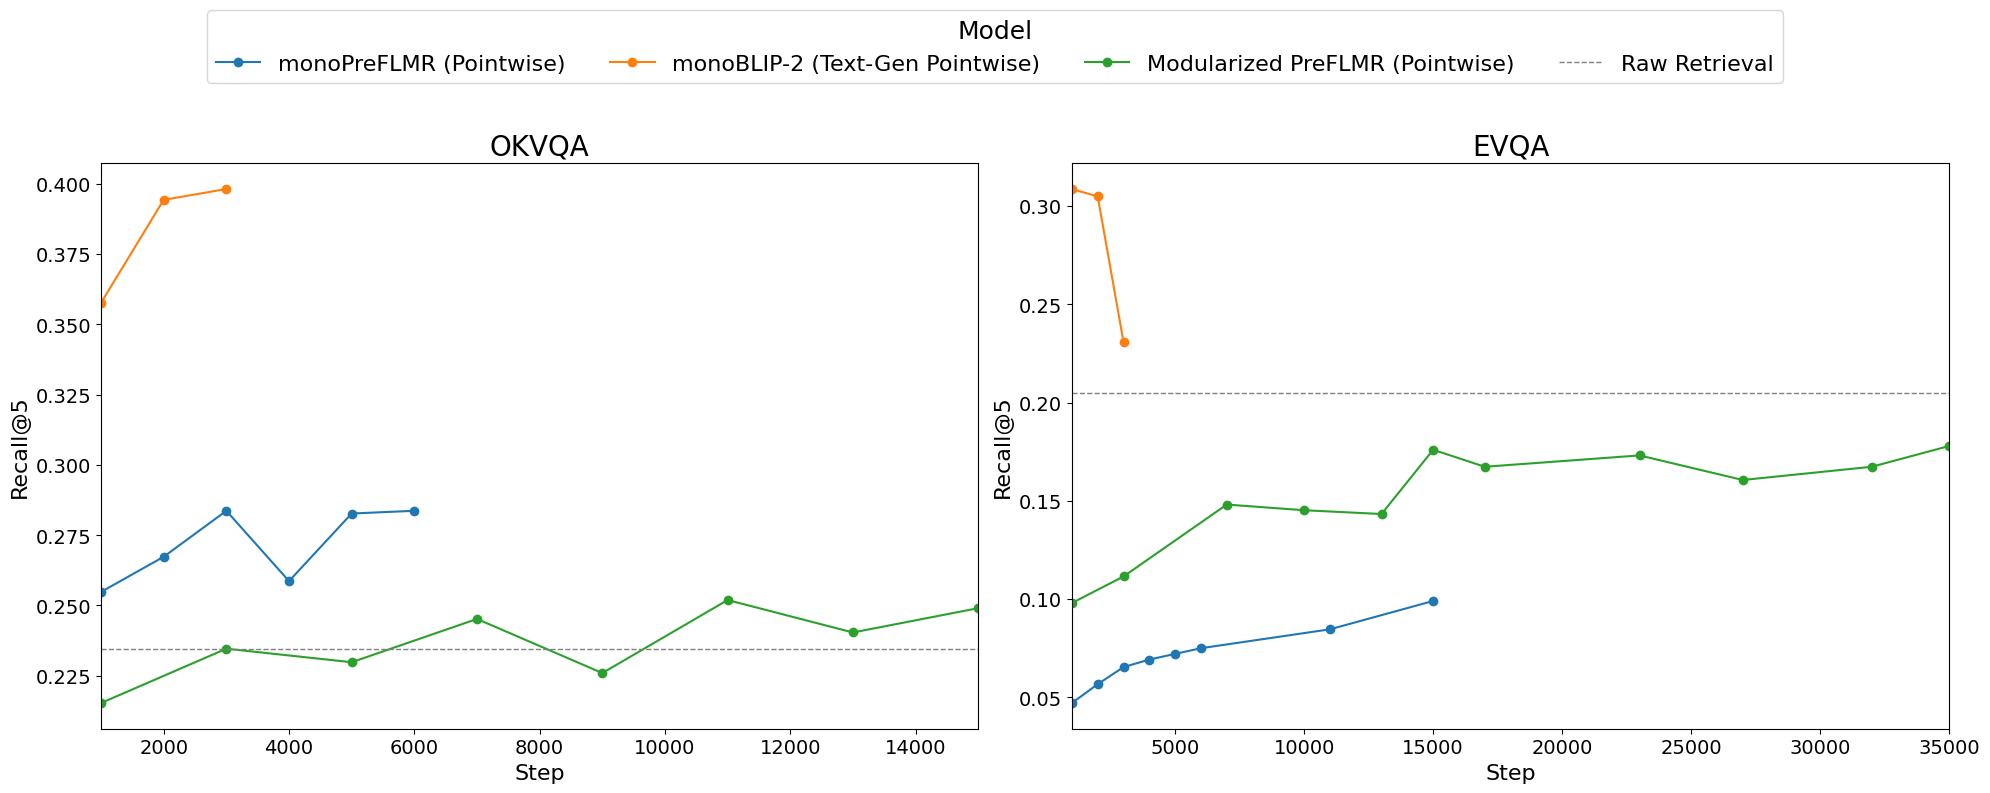

In [20]:
import matplotlib.pyplot as plt

# Data for first plot
data1 = {
    "monoPreFLMR (Pointwise)": {
        "Step": [1000, 2000, 3000, 4000, 5000, 6000],
        "Performance": [0.254807681, 0.267307699, 0.283653855, 0.258653849, 0.282692313, 0.283653855]
    },
    "monoBLIP-2 (Text-Gen Pointwise)": {
        "Step": [1000, 2000, 3000],
        "Performance": [0.3576, 0.394230783, 0.398076922]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000],
        "Performance": [0.2153, 0.234615386, 0.22980769, 0.245192304, 0.225961536, 0.251923084, 0.240384609, 0.249038458]
    }
}

# Data for second plot
data2 = {
    "monoPreFLMR (Pointwise)": {
        "Step": [1000, 2000, 3000, 4000, 5000, 6000, 11000, 15000],
        "Performance": [0.047115386, 0.05673077, 0.065384619, 0.069230773, 0.072115384, 0.075000003, 0.084615387, 0.099038459]
    },
    "monoBLIP-2 (Text-Gen Pointwise)": {
        "Step": [1000, 2000, 3000],
        "Performance": [0.3086, 0.304807693, 0.230769232]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [1000, 3000, 7000, 10000, 13000, 15000, 17000, 23000, 27000, 32000, 35000],
        "Performance": [0.0980, 0.1115, 0.148076922, 0.14519231, 0.143269226, 0.175961539, 0.16730769, 0.173076928, 0.160576925, 0.16730769, 0.177884609]
    }
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plot first set of data
for model, values in data1.items():
    axes[0].plot(values["Step"], values["Performance"], marker='o', label=model)
axes[0].set_xlabel('Step', fontsize = 16)
axes[0].set_ylabel('Recall@5', fontsize = 16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(False)
axes[0].set_title('OKVQA', fontsize = 20)
axes[0].set_xlim(1000, 15000)

# Add grey dotted line for Raw Retrieval for OKVQA and label it
axes[0].axhline(y=0.2346, color='grey', linestyle='--', linewidth=1, label='Raw Retrieval')

# Plot second set of data
for model, values in data2.items():
    axes[1].plot(values["Step"], values["Performance"], marker='o', label=model)
axes[1].set_xlabel('Step', fontsize = 16)
axes[1].set_ylabel('Recall@5', fontsize = 16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(False)
axes[1].set_title('EVQA', fontsize = 20)
axes[1].set_xlim(1000, 35000)

# Add grey dotted line for Raw Retrieval for EVQA and label it
axes[1].axhline(y=0.2048, color='grey', linestyle='--', linewidth=1, label='Raw Retrieval')

# Add a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, title='Model', fontsize=16, title_fontsize=18)

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()


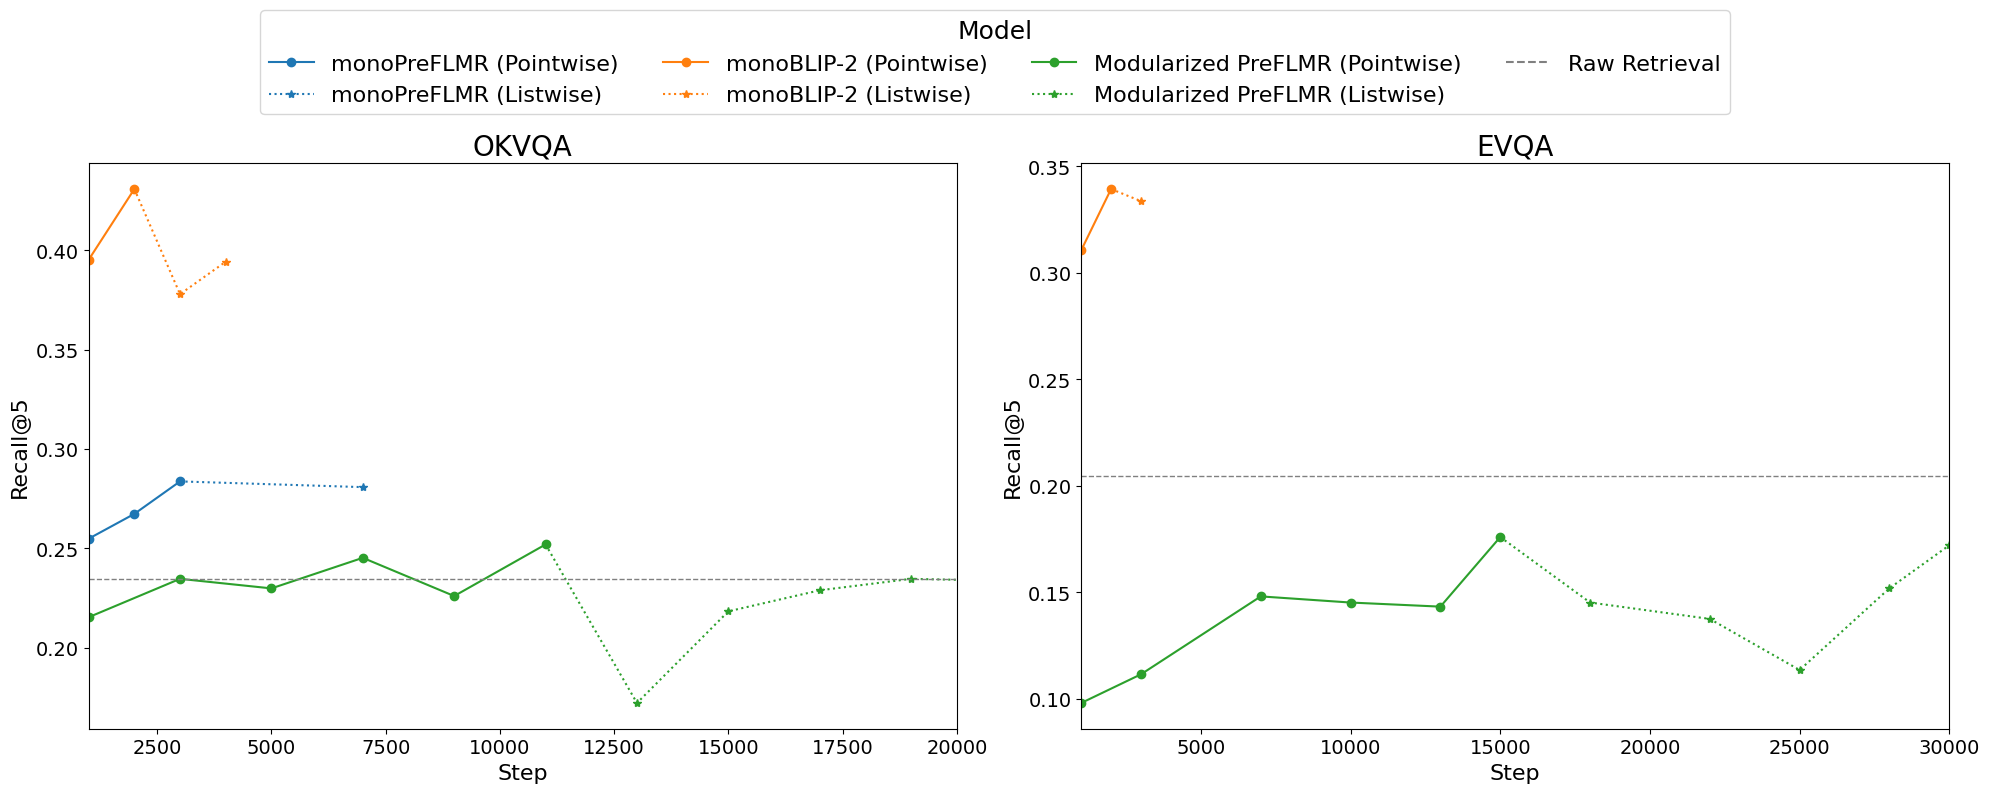

In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

data1 = {
    "monoPreFLMR (Pointwise)": {
        "Step": [1000, 2000, 3000],
        "Performance": [0.254807681, 0.267307699, 0.283653855]
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000, 2000],
        "Performance": [0.39519, 0.4308]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [1000, 3000, 5000, 7000, 9000, 11000],
        "Performance": [0.2153, 0.234615386, 0.22980769, 0.245192304, 0.225961536, 0.251923084]
    }
}

data2 = {
    "monoPreFLMR (Pointwise)": {
        "Step": [],
        "Performance": []
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000, 2000],
        "Performance": [0.31057, 0.3394]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [1000, 3000, 7000, 10000, 13000, 15000],
        "Performance": [0.0980, 0.1115, 0.148076922, 0.14519231, 0.143269226, 0.175961539]
    }
}

data1_neg_sample_extend = {
    "monoPreFLMR (Pointwise)": {
        "Step": [4000],
        "Performance": [0.280769229]
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000, 2000],
        "Performance": [0.377884626, 0.394230783]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [2000, 4000, 6000, 8000, 10000],
        "Performance": [0.172115386, 0.218269229, 0.228846148, 0.234615386, 0.233653843]
    }
}

data2_neg_sample_extend = {
    "monoPreFLMR (Pointwise)": {
        "Step": [],
        "Performance": []
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000],
        "Performance": [0.3337]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [3000, 7000, 10000, 13000, 15000],
        "Performance": [0.1452, 0.1375, 0.1135, 0.1519, 0.1721]
    }
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
color_map = {}
# Plot first set of data and extend with dotted lines
for model, values in data1.items():
    line, = axes[0].plot(values["Step"], values["Performance"], marker='o', label=model)
    color = line.get_color()
    color_map[model.split(' ')[0]] = color 
    if model in data1_neg_sample_extend:
        last_step = values["Step"][-1]
        last_performance = values["Performance"][-1]
        ext_steps = [last_step + step for step in data1_neg_sample_extend[model]["Step"]]
        ext_performances = [last_performance] + data1_neg_sample_extend[model]["Performance"]
        combined_steps = [last_step] + ext_steps
        axes[0].plot(combined_steps, ext_performances, marker='*', linestyle=':', color=color)

axes[0].set_xlabel('Step', fontsize=16)
axes[0].set_ylabel('Recall@5', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(False)
axes[0].set_title('OKVQA', fontsize=20)
axes[0].set_xlim(1000, 20000)
# Add grey dotted line for Raw Retrieval for OKVQA and label it
axes[0].axhline(y=0.2346, color='grey', linestyle='--', linewidth=1, label='Raw Retrieval')

# Plot second set of data and extend with dotted lines
for model, values in data2.items():
    line, = axes[1].plot(values["Step"], values["Performance"], marker='o', label=model)
    color = line.get_color()
    if model in data2_neg_sample_extend:
        try:
            last_step = values["Step"][-1]
            last_performance = values["Performance"][-1]
            ext_steps = [last_step + step for step in data2_neg_sample_extend[model]["Step"]]
            ext_performances = [last_performance] + data2_neg_sample_extend[model]["Performance"]
            combined_steps = [last_step] + ext_steps
            axes[1].plot(combined_steps, ext_performances, marker='*', linestyle=':', color=color)
        except:
            pass

axes[1].set_xlabel('Step', fontsize=16)
axes[1].set_ylabel('Recall@5', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(False)
axes[1].set_title('EVQA', fontsize=20)
axes[1].set_xlim(1000, 30000)
# Add grey dotted line for Raw Retrieval for EVQA and label it
axes[1].axhline(y=0.2048, color='grey', linestyle='--', linewidth=1, label='Raw Retrieval')

# Add a single legend for both plots with manual entries for Retrieved Extend
pointwise_handles = [mlines.Line2D([], [], color=color_map['monoPreFLMR'], marker='o', linestyle='-', label='monoPreFLMR (Pointwise)'),
                     mlines.Line2D([], [], color=color_map['monoPreFLMR'], marker='*', linestyle=':', label='monoPreFLMR (Listwise)'),
                     mlines.Line2D([], [], color=color_map['monoBLIP-2'], marker='o', linestyle='-', label='monoBLIP-2 (Pointwise)'),
                     mlines.Line2D([], [], color=color_map['monoBLIP-2'], marker='*', linestyle=':', label='monoBLIP-2 (Listwise)'),
                     mlines.Line2D([], [], color=color_map['Modularized'], marker='o', linestyle='-', label='Modularized PreFLMR (Pointwise)'),
                     mlines.Line2D([], [], color=color_map['Modularized'], marker='*', linestyle=':', label='Modularized PreFLMR (Listwise)')]


raw_retrieval_handle = [mlines.Line2D([], [], color='grey', linestyle='--', label='Raw Retrieval')]

fig.legend(handles=pointwise_handles  + raw_retrieval_handle, loc='upper center', ncol=4, title='Model', fontsize=16, title_fontsize=18)

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()


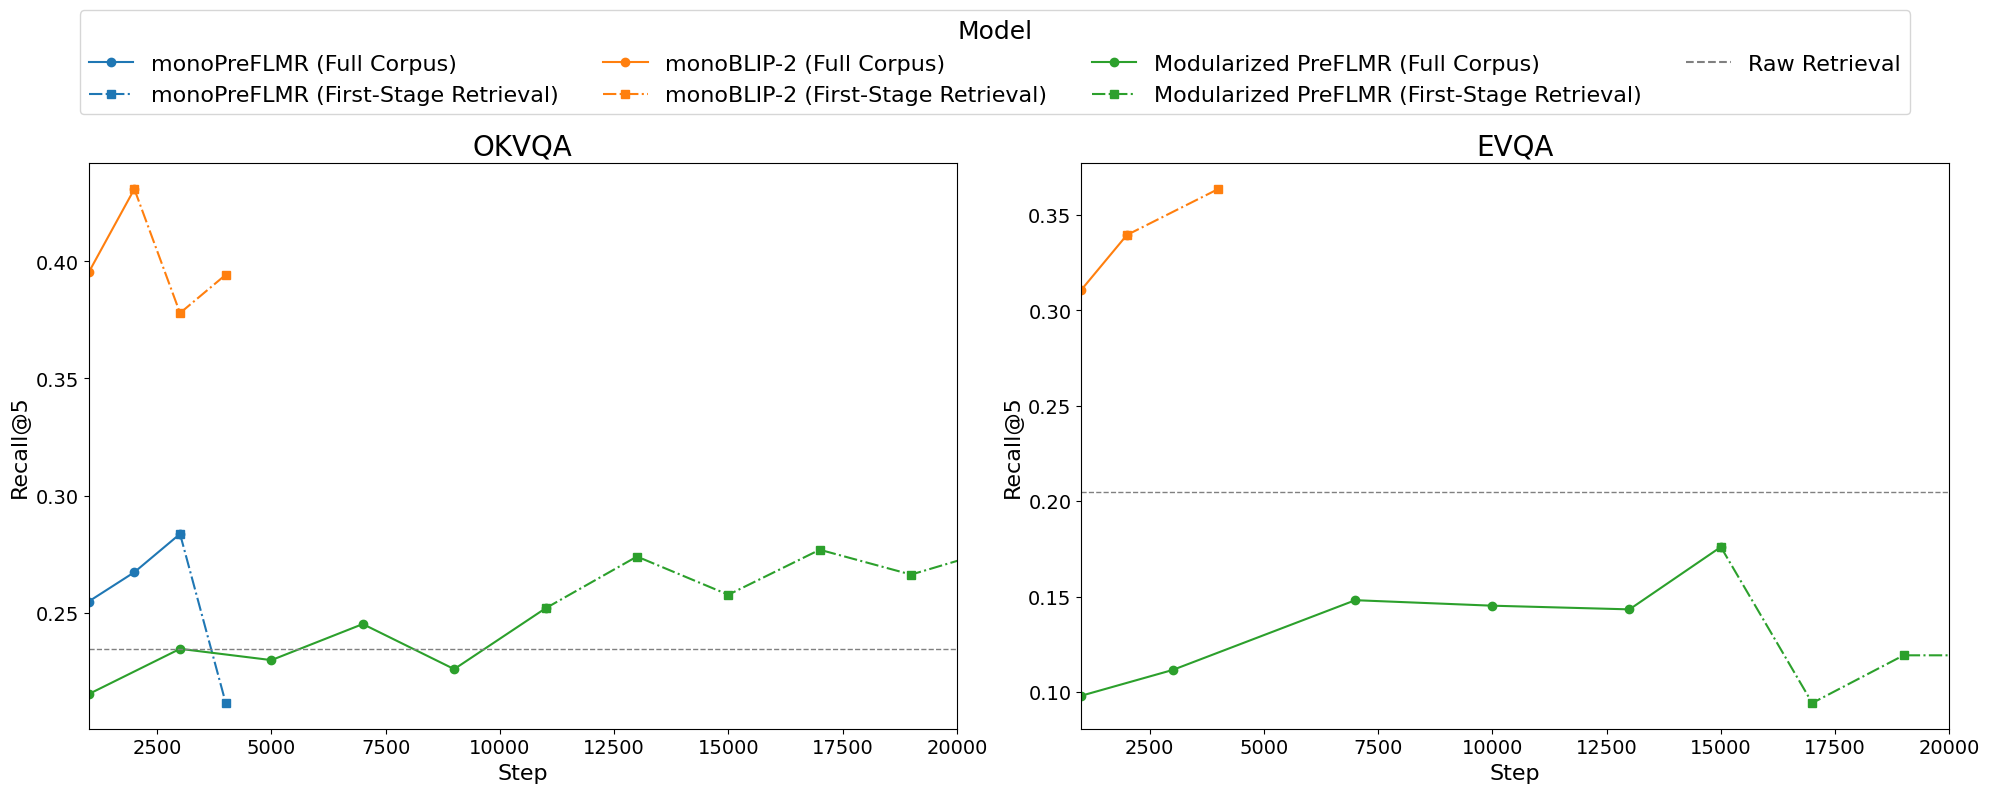

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

data1 = {
    "monoPreFLMR (Pointwise)": {
        "Step": [1000, 2000, 3000],
        "Performance": [0.254807681, 0.267307699, 0.283653855]
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000, 2000],
        "Performance": [0.39519, 0.4308]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [1000, 3000, 5000, 7000, 9000, 11000],
        "Performance": [0.2153, 0.234615386, 0.22980769, 0.245192304, 0.225961536, 0.251923084]
    }
}

data2 = {
    "monoPreFLMR (Pointwise)": {
        "Step": [],
        "Performance": []
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000, 2000],
        "Performance": [0.31057, 0.3394]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [1000, 3000, 7000, 10000, 13000, 15000],
        "Performance": [0.098, 0.1115, 0.148076922, 0.14519231, 0.143269226, 0.175961539]
    }
}

data1_retrieved_extend = {
    "monoPreFLMR (Pointwise)": {
        "Step": [1000],
        "Performance": [0.2115]
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [1000, 2000],
        "Performance": [0.377884626, 0.394230783]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [2000, 4000, 6000, 8000, 10000],
        "Performance": [0.274, 0.2577, 0.2769, 0.2663, 0.2779]
    }
}
data2_retrieved_extend = {
    "monoPreFLMR (Pointwise)": {
        "Step": [],
        "Performance": []
    },
    "monoBLIP-2 (Pointwise)": {
        "Step": [2000],
        "Performance": [0.3635]
    },
    "Modularized PreFLMR (Pointwise)": {
        "Step": [2000, 4000, 6000, 8000],
        "Performance": [0.0942, 0.1192, 0.1192, 0.1096]
    }
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Define a dictionary to store the colors
color_map = {}
# Plot first set of data and extend with dotted lines
for model, values in data1.items():
    line, = axes[0].plot(values["Step"], values["Performance"], marker='o', label=model)
    color = line.get_color()
    color = line.get_color()
    color_map[model.split(' ')[0]] = color 
    if model in data1_retrieved_extend:
        last_step = values["Step"][-1]
        last_performance = values["Performance"][-1]
        ext_steps = [last_step + step for step in data1_retrieved_extend[model]["Step"]]
        ext_performances = [last_performance] + data1_retrieved_extend[model]["Performance"]
        combined_steps = [last_step] + ext_steps
        axes[0].plot(combined_steps, ext_performances, marker='s', linestyle='-.', color=color)

axes[0].set_xlabel('Step', fontsize=16)
axes[0].set_ylabel('Recall@5', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid(False)
axes[0].set_title('OKVQA', fontsize=20)
axes[0].set_xlim(1000, 20000)
# Add grey dotted line for Raw Retrieval for OKVQA and label it
axes[0].axhline(y=0.2346, color='grey', linestyle='--', linewidth=1, label='Raw Retrieval')

# Plot second set of data and extend with dotted lines
for model, values in data2.items():
    line, = axes[1].plot(values["Step"], values["Performance"], marker='o', label=model)
    color = line.get_color()
    if model in data2_retrieved_extend:
        try:
            last_step = values["Step"][-1]
            last_performance = values["Performance"][-1]
            ext_steps = [last_step + step for step in data2_retrieved_extend[model]["Step"]]
            ext_performances = [last_performance] + data2_retrieved_extend[model]["Performance"]
            combined_steps = [last_step] + ext_steps
            axes[1].plot(combined_steps, ext_performances, marker='s', linestyle='-.', color=color)
        except:
            pass

axes[1].set_xlabel('Step', fontsize=16)
axes[1].set_ylabel('Recall@5', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(False)
axes[1].set_title('EVQA', fontsize=20)
axes[1].set_xlim(1000, 20000)
# Add grey dotted line for Raw Retrieval for EVQA and label it
axes[1].axhline(y=0.2048, color='grey', linestyle='--', linewidth=1, label='Raw Retrieval')

# Add a single legend for both plots with manual entries for Retrieved Extend
pointwise_handles = [mlines.Line2D([], [], color=color_map['monoPreFLMR'], marker='o', linestyle='-', label='monoPreFLMR (Full Corpus)'),
                     mlines.Line2D([], [], color=color_map['monoPreFLMR'], marker='s', linestyle='-.', label='monoPreFLMR (First-Stage Retrieval)'),
                     mlines.Line2D([], [], color=color_map['monoBLIP-2'], marker='o', linestyle='-', label='monoBLIP-2 (Full Corpus)'),
                     mlines.Line2D([], [], color=color_map['monoBLIP-2'], marker='s', linestyle='-.', label='monoBLIP-2 (First-Stage Retrieval)'),
                     mlines.Line2D([], [], color=color_map['Modularized'], marker='o', linestyle='-', label='Modularized PreFLMR (Full Corpus)'),
                     mlines.Line2D([], [], color=color_map['Modularized'], marker='s', linestyle='-.', label='Modularized PreFLMR (First-Stage Retrieval)')]


raw_retrieval_handle = [mlines.Line2D([], [], color='grey', linestyle='--', label='Raw Retrieval')]

fig.legend(handles=pointwise_handles  + raw_retrieval_handle, loc='upper center', ncol=4, title='Model', fontsize=16, title_fontsize=18)
# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()


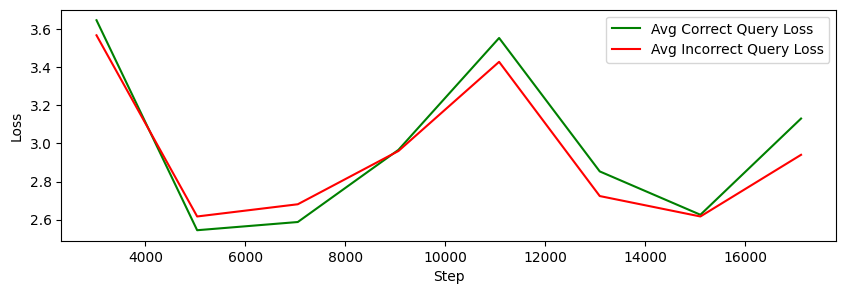

In [3]:
import matplotlib.pyplot as plt

def plot_loss_vs_step():
    # Data from the table
    steps = [3021, 5035, 7049, 9063, 11077, 13091, 15105, 17119]
    correct_avg_loss = [3.645, 2.545, 2.588, 2.966, 3.552, 2.853, 2.626, 3.130]
    incorrect_avg_loss = [3.566, 2.617, 2.681, 2.960, 3.427, 2.724, 2.617, 2.940]

    # Plotting
    plt.figure(figsize=(10, 3))
    plt.plot(steps, correct_avg_loss, 'g-', label='Avg Correct Query Loss')  # Green line
    plt.plot(steps, incorrect_avg_loss, 'r-', label='Avg Incorrect Query Loss')  # Red line

    # Adding titles and labels
    plt.xlabel('Step')
    plt.ylabel('Loss')

    # Adding legend
    plt.legend()

    # Show plot
    plt.show()

# Call the function to plot
plot_loss_vs_step()
